In [1]:
# Cell 1 ‑‑‑ imports and cube loading
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

# --------- file location (edit if needed) ----------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("Loading:", cube_path.resolve())

with fits.open(cube_path) as hdul:
    data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
    stat = hdul["STAT"].data.astype(np.float32)
    dq   = hdul["DQ"].data.astype(np.uint8)
    hdr  = hdul["DATA"].header

nz, ny, nx = data.shape
print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
print("Header info:", hdr)


Loading: /Users/maclaptop29/Desktop/ICRAR/data/IC3392/IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
Cube dimensions  →  nz = 3761,  ny = 438,  nx = 437
Header info: XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  437                                                  NAXIS2  =                  438                                                  NAXIS3  =                 3761                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            CRPIX2  =      219.93673592818 / P

In [2]:
# Cell 2  –– wavelength array (Å), λ‑cut, velocity scale
from astropy.wcs import WCS

# --- 2.1 build wavelength array in Å ---
wcs_3d = WCS(hdr)                       # 3‑D WCS (RA, Dec, λ)
spec_pix = np.arange(nz)                # spectral pixel indices (0 … nz‑1)

# all_pix2world returns metres for the spectral axis in this cube → convert to Å
lam_m  = wcs_3d.all_pix2world(
             np.zeros_like(spec_pix),   # dummy RA
             np.zeros_like(spec_pix),   # dummy Dec
             spec_pix,                  # spectral pixel
             0)[2]                      # wavelength [m]
lam_ang = lam_m * 1e10                  # metres → Å

# --- 2.2 keep only λ < 7000 Å ---
cut = (lam_ang >= 4750.0) & (lam_ang <= 7000.0)
lam_ang = lam_ang[cut]
data    = data[cut, :, :]
stat    = stat[cut, :, :]
dq      = dq[cut,   :, :]
nz      = lam_ang.size                 # update nz after trimming
print(f"After λ‑cut (<=7000 Å)  →  nz = {nz}")

# --- 2.3 compute velocity scale (km s⁻¹ per pixel) ---
c_kms   = c.c.to(u.km/u.s).value        # 299 792.458
dlnλ    = np.log(lam_ang[1:]) - np.log(lam_ang[:-1])
velscale = np.min(c_kms * dlnλ)
print(f"Velocity scale (min)  →  velscale = {velscale:.2f} km/s")


After λ‑cut (<=7000 Å)  →  nz = 1800
Velocity scale (min)  →  velscale = 53.55 km/s


Integrated spectrum built:
   weighted flux shape : (1800,)
   simple‑sum shape    : (1800,)


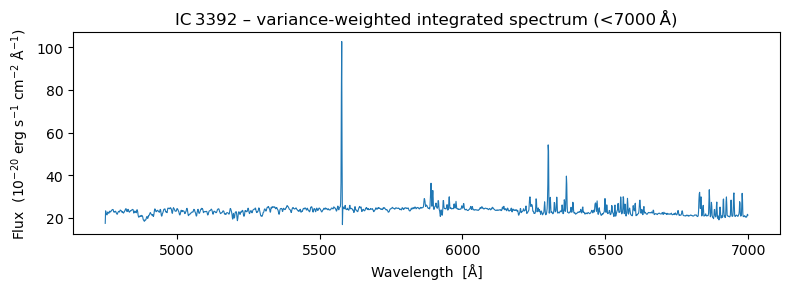

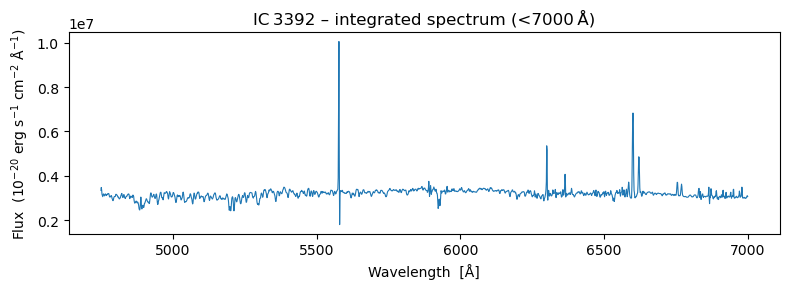

In [3]:
# Cell 3 –– integrate cube to 1‑D spectrum + noise  (v2: NaN‑safe)
# ----------------------------------------------------------------
good = (dq == 0) & np.isfinite(data) & np.isfinite(stat) & (stat > 0)

ivar = np.zeros_like(stat)
ivar[good] = 1.0 / stat[good]           # 1/σ²   (units: Å² cm⁴ s² erg⁻²)

# ---- 3.1 variance‑weighted spectrum ---- 
wgt_sum   = np.nansum(ivar,                axis=(1, 2))      # Σ 1/σ²
zero_wgt  = (wgt_sum == 0)                                   # empty planes

flux_wgt  = np.full(nz, np.nan, dtype=np.float32)
noise_wgt = np.full(nz, np.nan, dtype=np.float32)

valid     = ~zero_wgt
flux_wgt[valid]  = (np.nansum(data[valid] * ivar[valid], axis=(1, 2))
                    / wgt_sum[valid])
noise_wgt[valid] = np.sqrt(1.0 / wgt_sum[valid])

# ---- 3.2 simple‑sum spectrum (for luminosity) ----
flux_sum  = np.nansum(data * good, axis=(1, 2))          # erg s⁻¹ cm⁻² Å⁻¹
pix_sum   = np.nansum(good,        axis=(1, 2))          # # valid spaxels

print("Integrated spectrum built:")
print(f"   weighted flux shape : {flux_wgt.shape}")
print(f"   simple‑sum shape    : {flux_sum.shape}")

# ---- 3.3 quick plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_wgt, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – variance‑weighted integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()


Hα‑based red‑shift  z = 0.00567   (v ≈ 1699.3 km/s)
Masked wavelength bins : 328 of 1800 (18.2 %)


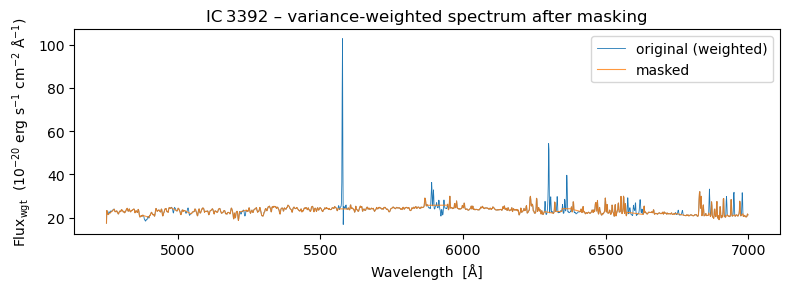

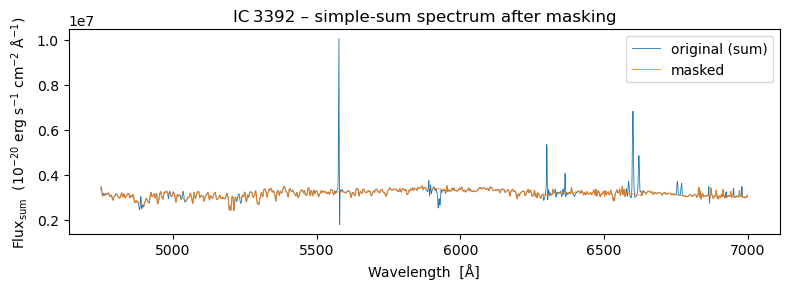

In [4]:
# Cell 4 –– red‑shift guess & dual‑spectra masking (sky ≠ red‑shifted)
# -------------------------------------------------------------------
import numpy as np

# -- 4.1  red‑shift from Hα using the simple‑sum spectrum --------------
h_alpha_lab = 6562.8
win = (lam_ang > 6500) & (lam_ang < 6700)
lam_peak = lam_ang[win][np.nanargmax(flux_sum[win])]
z_guess  = lam_peak / h_alpha_lab - 1
v_guess  = z_guess * c_kms
print(f"Hα‑based red‑shift  z = {z_guess:.5f}   (v ≈ {v_guess:.1f} km/s)")

# -- 4.2  read mask table ------------------------------------------------
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_tbl  = np.genfromtxt("specMask_KIN.txt", dtype=mask_dtype,
                          comments='#', usecols=(0,1,2), encoding=None)

# -- 4.3  construct bad‑pixel mask --------------------------------------
mask_bad = np.zeros_like(lam_ang, dtype=bool)

for lam_rest, width_rest, comment in mask_tbl:
    # sky lines: use rest value directly (no z shift)
    if comment.strip().lower() == 'sky':
        lam_obs   = lam_rest
        width_obs = width_rest
    else:                       # nebular/emission lines → red‑shifted
        lam_obs   = lam_rest  * (1 + z_guess)
        width_obs = width_rest * (1 + z_guess)

    m = (lam_ang > lam_obs - width_obs/2) & (lam_ang < lam_obs + width_obs/2)
    mask_bad |= m

print(f"Masked wavelength bins : {mask_bad.sum()} of {lam_ang.size} "
      f"({100*mask_bad.mean():.1f} %)")

# --- 4.4 replace masked pixels with local mean along the wavelength axis ---

def fill_bad_1d(spec, bad):
    """
    spec : 1‑D array  (your flux vector)
    bad  : 1‑D bool   (True where you want to replace)
    Returns a *new* array with bad entries replaced by the
    mean of the nearest good pixels on either side.
    """
    filled = spec.copy()

    if bad.any():
        good = ~bad
        # np.interp does linear interpolation; for a single pixel gap
        # that is exactly the mean of its two neighbours
        filled[bad] = np.interp(np.flatnonzero(bad),         # x  to fill
                                np.flatnonzero(good),        # x of neighbours
                                spec[good])                  # y of neighbours
    return filled

# 1‑D masks (length = nz)
bad_1d = mask_bad.copy()

flux_wgt_masked = fill_bad_1d(flux_wgt, bad_1d)
flux_sum_masked = fill_bad_1d(flux_sum, bad_1d)

# keep the noise = ∞ so pPXF still gives zero weight there
noise_wgt_masked = noise_wgt.copy()
noise_wgt_masked[bad_1d] = np.inf

# -- 4.5  quick visual check (two separate plots) -----------------------

# plot 1: variance‑weighted spectrum
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_wgt,        lw=0.6, label='original (weighted)')
plt.plot(lam_ang, flux_wgt_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{wgt}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – variance‑weighted spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()

# plot 2: simple‑sum spectrum
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_sum,        lw=0.6, label='original (sum)')
plt.plot(lam_ang, flux_sum_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – simple‑sum spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()


# ---- outputs for Cell 5 ----
# lam_ang, flux_wgt_masked, noise_wgt_masked, flux_sum_masked


In [5]:
# Cell 5 –– log‑rebinning the chosen 1‑D spectrum
# -----------------------------------------------
from ppxf import ppxf_util

# ----- 5.0  choose which spectrum to fit with pPXF -----
use_weighted = False     # True -> variance‑weighted, False -> simple‑sum

if use_weighted:
    flux_1d_raw  = flux_wgt_masked
    noise_1d_raw = noise_wgt_masked
    spec_tag     = "variance‑weighted"
else:
    flux_1d_raw  = flux_sum_masked
    # noise from summed variances (shot‑noise approximation)
    noise_1d_raw = np.sqrt(np.nansum(stat, axis=(1,2)))
    noise_1d_raw[mask_bad] = np.inf
    spec_tag     = "simple‑sum"

print(f"Preparing {spec_tag} spectrum for pPXF …")

# --- 5.0a  make NaN‑/Inf‑safe copies ---------------------------------
flux_1d  = np.nan_to_num(flux_1d_raw,  nan=0.0, posinf=0.0, neginf=0.0)
noise_1d = np.nan_to_num(noise_1d_raw, nan=np.inf, posinf=np.inf, neginf=np.inf)
noise_1d[noise_1d <= 0] = np.inf

# --- 5.1  finite wavelength range ------------------------------------
lam_finite = lam_ang[np.isfinite(flux_1d)]
lam_range  = [lam_finite.min(), lam_finite.max()]      # Å

# --- 5.2  log‑rebin flux and noise -----------------------------------
# 5.2a  initial rebin just to measure velscale_out
_, _, velscale_out = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d, velscale=velscale, flux=True)

# 5.2b  rebin flux & noise *with* the measured velscale_out
log_flux, log_lam, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d,
    velscale=velscale_out, flux=True)

log_noise, _, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], noise_1d,
    velscale=velscale_out, flux=False)

# 5.3  clean the noise as before
bad = ~np.isfinite(log_noise) | (log_noise <= 0)
log_noise[bad] = np.inf
log_noise[~np.isfinite(log_noise) | (log_noise <= 0)] = np.inf
# Force NaN/Inf to be median noise
log_noise[~np.isfinite(log_noise)] = np.nanmedian(log_noise)
# # Force zero flux to be median values
# log_flux[log_flux == 0] = np.nanmedian(log_flux)

print(f"Log‑grid length : {log_flux.size} pixels")
print(f"velscale        : {velscale_out:.3f} km/s  (should match ~53.5)")

assert np.isclose(velscale_out, velscale), \
       "Warning: velscale mismatch! Check your data."

# ---- outputs for the next cell ----
#   log_flux, log_noise, log_lam, velscale_out, z_guess


Preparing simple‑sum spectrum for pPXF …
Log‑grid length : 2171 pixels
velscale        : 53.549 km/s  (should match ~53.5)


/Users/maclaptop29/miniconda3/envs/ICRAR/lib/python3.13/site-packages/ppxf/ppxf_util.py:173: RuntimeWarning: invalid value encountered in multiply
  specNew.T[...] *= np.diff(k) > 0                      # fix for design flaw of reduceat()
/Users/maclaptop29/miniconda3/envs/ICRAR/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1496: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/maclaptop29/miniconda3/envs/ICRAR/lib/python3.13/site-packages/ppxf/ppxf_util.py:174: RuntimeWarning: invalid value encountered in add
  specNew.T[...] += np.diff(((newBorders - borders[k]))*spec[k].T)    # Add to 1st dimension


In [6]:
# Cell 6 –– load E‑MILES templates, match FWHM, log‑rebin
# -------------------------------------------------------
from urllib import request
import numpy as np
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import ppxf.sps_util as lib

# 6.1  find or fetch the .npz file
ppxf_dir  = Path(lib.__file__).parent
basename  = "spectra_emiles_9.0.npz"
filename  = ppxf_dir / "sps_models" / basename
filename.parent.mkdir(exist_ok=True)

if not filename.is_file():
    url = f"https://raw.githubusercontent.com/micappe/ppxf_data/main/{basename}"
    print(f"Downloading {basename} …")
    request.urlretrieve(url, filename)

print("Loading E‑MILES SSP grid …")
sps = lib.sps_lib(filename, velscale_out, fwhm_gal=None,
                  norm_range=[5070, 5950])        # minimalist call

# ----- unpack template arrays -----------------------------------------
templates_hr = sps.templates
lam_temp_hr  = sps.lam_temp

# ---- robust FWHM retrieval -------------------------------------------
try:
    fwhm_temp = sps.fwhm_tem          # new pPXF versions
except AttributeError:
    try:
        fwhm_temp = sps.fwhm          # older field name
    except AttributeError:
        # last resort: read directly from the .npz file
        with np.load(filename) as npz:
            fwhm_temp = npz["fwhm"]   # (N_pix_hr,) array
print(f"FWHM array length : {np.size(fwhm_temp)}  (pulled successfully)")

# ----- make fwhm_temp the same length as lam_temp_hr ------------------
if np.size(fwhm_temp) != lam_temp_hr.size:
    from scipy.interpolate import interp1d
    # build an interpolator over the original FWHM grid (assumed monotonic)
    idx_full = np.linspace(0, 1, lam_temp_hr.size)
    idx_fwhm = np.linspace(0, 1, np.size(fwhm_temp))
    f_interp = interp1d(idx_fwhm, fwhm_temp, kind='linear',
                        bounds_error=False, fill_value=fwhm_temp[-1])
    fwhm_temp = f_interp(idx_full)        # now length = 18 998

# optional: M/L vector if present
ml_temp = getattr(sps, "ml", None)

print(f"templates_hr shape : {templates_hr.shape}")
print(f"λ grid length      : {lam_temp_hr.size}")
print(f"FWHM array length  : {np.size(fwhm_temp)}")
print("M/L available?     :", ml_temp is not None)

print(f"{templates_hr.shape[0]} templates, λ‑range {lam_temp_hr[0]:.1f}–{lam_temp_hr[-1]:.1f} Å")
print(  f"{fwhm_temp.min():.2f}–{fwhm_temp.max():.2f} Å")

# -------- 6.2  wavelength‑dependent MUSE LSF from Emsellem+2022 -------
# FWHM(λ) [Å] = 5.866×10⁻⁸ λ² – 9.187×10⁻⁴ λ + 6.040
fwhm_muse = (5.866e-8 * lam_temp_hr**2
             - 9.187e-4 * lam_temp_hr
             + 6.040)

# -------- 6.3  convolve each template to MUSE resolution ---------------
n_wave, n_age, n_Z = templates_hr.shape
templates_conv = np.empty_like(templates_hr.reshape(n_wave, -1))  # 2‑D view
dlam_temp      = np.gradient(lam_temp_hr)

# pre‑compute σ arrays in pixel units (same for every template)
sigma_muse = fwhm_muse / 2.355
sigma_temp = fwhm_temp / 2.355
sigma_diff = np.sqrt(np.clip(sigma_muse**2 - sigma_temp**2, 0, None))
sigma_pix  = sigma_diff / dlam_temp        # 1‑D array length = n_wave

for j in range(templates_conv.shape[1]):   # loop over age/Z combinations
    spec1d = templates_hr[:, j // n_Z, j % n_Z]  # slice to 1‑D
    templates_conv[:, j] = ppxf_util.gaussian_filter1d(spec1d, sigma_pix)

# restore original (n_wave, n_age, n_Z) shape for log‑rebin
templates_conv = templates_conv.reshape(n_wave, n_age, n_Z)
print(f"Convolved templates shape : {templates_conv.shape}")
print(f"λ range : {lam_temp_hr[0]:.1f}–{lam_temp_hr[-1]:.1f} Å")
print(f"FWHM range : {fwhm_temp.min():.2f}–{fwhm_temp.max():.2f} Å")
print(f"FWHM range (MUSE) : {fwhm_muse.min():.2f}–{fwhm_muse.max():.2f} Å")

# -------- 6.4  log‑rebin templates (λ, N_templates) --------------------
log_temp2d, log_lam_temp, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]],           # ← *same* λ-range you used for galaxy
    templates_conv.reshape(n_wave, -1),
    velscale=velscale_out,
    flux=True)

# now simply transpose to (n_templates, npix) — no trimming needed
log_temp = log_temp2d.T

print("Template matrix shape (final):", log_temp.shape)
print("Galaxy spectrum shape (final):", log_flux.shape)
print("Galxy noise shape (final):", log_noise.shape)

# # -------- 6.6  normalise templates over 5070–5950 Å ------------------
# # Convert log-wavelength back to Å
# # (ppxf_util.log_rebin uses natural log, so)
# lam_lin = np.exp(log_lam_temp)  

# # Build a proper mask in linear Å
# mask_norm = (lam_lin > 5070) & (lam_lin < 5950)
# if not np.any(mask_norm):
#     raise ValueError("No pixels in the normalisation band — check log_lam_temp units")

# # Compute median of each template over that band
# norm = np.median(log_temp[:, mask_norm], axis=1)

# # Divide each template by its median (avoids NaNs)
# log_temp /= norm[:, None]

# ---- outputs for Cell 7 (pPXF fit) ----
#   log_flux, log_noise, log_lam, log_temp, log_lam_temp, ml_temp, velscale_out, z_guess

# ---- Insert this at the very bottom of Cell 6, before you move to Cell 7 ----

# # 6.X  — Align galaxy vectors to the template grid
# mask_gal = (log_lam >= log_lam_temp[ 0]) & (log_lam <= log_lam_temp[-1])
# log_lam   = log_lam[mask_gal]
# log_flux  = log_flux[mask_gal]
# log_noise = log_noise[mask_gal]

# # Confirm perfect shape match
# print("After alignment:")
# print(f"  template pixels  = {log_temp.shape[1]}")
# print(f"  galaxy  pixels   = {log_lam.size}")
# assert log_temp.shape[1] == log_lam.size, "Still a mismatch!"

# ---- Now you can safely start Cell 7, knowing shapes line up exactly. ----
# --- 6.X  force pixel grids to match exactly -------------------------
minpix = min(log_temp.shape[1], log_flux.shape[0])   # 2229 here
log_temp      = log_temp[:, :minpix]                 # trim template matrix
log_lam_temp  = log_lam_temp[:minpix]                # same for λ axis
log_flux      = log_flux[:minpix]                    # trim galaxy flux
log_noise     = log_noise[:minpix]                   # trim galaxy noise
log_lam       = log_lam[:minpix]                     # trim galaxy λ
print(f"Pixel match achieved → templates = galaxy = {minpix}")



Loading E‑MILES SSP grid …
FWHM array length : 16675  (pulled successfully)
templates_hr shape : (18998, 25, 6)
λ grid length      : 18998
FWHM array length  : 18998
M/L available?     : False
18998 templates, λ‑range 1679.9–49997.1 Å
2.51–23.57 Å
Convolved templates shape : (18998, 25, 6)
λ range : 1679.9–49997.1 Å
FWHM range : 2.51–23.57 Å
FWHM range (MUSE) : 2.44–106.74 Å
Template matrix shape (final): (150, 2170)
Galaxy spectrum shape (final): (2171,)
Galxy noise shape (final): (2171,)
Pixel match achieved → templates = galaxy = 2170


Outliers: 2062
Outliers: 3
Outliers: 1
Outliers: 1
Outliers: 2083
Outliers: 1
Outliers: 2082
Outliers: 2
Outliers: 2083
Outliers: 1
Outliers: 2083
Outliers: 1
 Best Fit:       Vel     sigma
 comp.  0:      1645        35
chi2/DOF: 2.333; DOF: 84; degree = 12; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 114; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 8/150
V = 1645.417 km/s, σ = 35.058 km/s


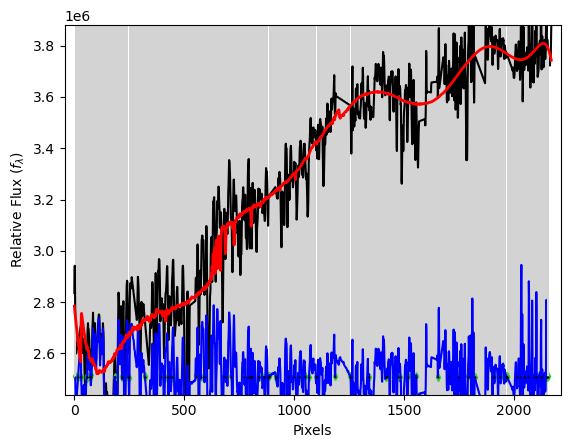

In [13]:
# Now run pPXF on the masked vectors:
from ppxf import ppxf

pp = ppxf.ppxf(
        templates   = log_temp.T,   #  <-- TRANSPOSE!
        galaxy      = log_flux,
        noise       = log_noise,
        velscale    = velscale_out,
        start       = [z_guess*c_kms, velscale_out],
        degree      = 12,
        mdegree     = -1,
        moments     = 2,
        goodpixels  = np.where(np.isfinite(log_flux))[0],
        clean       = True, 
        plot        = True,)

print(f"V = {pp.sol[0]:.3f} km/s, σ = {pp.sol[1]:.3f} km/s")


In [8]:
from speclite import filters
f_r   = filters.load_filter('sdss2010-r')   # SDSS‑r throughput
lam_r = f_r.wavelength          # ← already a NumPy array of Å
R_r   = f_r.response            # dimensionless 0–1


with np.load(filename) as f:        # filename = spectra_emiles_9.0.npz
    mass_grid = f["masses"]         # shape (25, 6)

mass_vec = mass_grid.ravel()        # (150,)

# mass locked in stars per template, weighted by light fraction
mass_weighted = pp.weights * mass_vec       # (150,)

M_star_ap = mass_weighted.sum()             # aperture stellar mass  (M☉ * arbitrary scale)

lam_cont = np.exp(log_lam_temp)             # Å
F_lambda = pp.bestfit                       # 10⁻²⁰ erg s⁻¹ cm⁻² Å⁻¹ per pixel

# Convert to f_ν  (erg s⁻¹ cm⁻² Hz⁻¹)
f_nu = F_lambda * lam_cont**2 / (c.c.to('Å/s').value)

# Integrate under the SDSS‑r filter
R_int = np.interp(lam_cont, lam_r, R_r, left=0, right=0)
F_r_ab = np.trapezoid(f_nu * R_int, lam_cont)   # 10⁻²⁰ erg s⁻¹ cm⁻² Hz⁻¹

AB_zeropoint = 3631e-23                  # erg s^-1 cm^-2 Hz^-1 for 0 mag
m_r = -2.5*np.log10(F_r_ab*1e-20 / AB_zeropoint)
M_r = m_r - 31.09                       # Virgo DM

L_r_Lsun = 10**(-0.4*(M_r - 4.64))      # L_☉
scale = L_r_Lsun / pp.weights.sum()     # converts light‑weighted sums to L_☉

M_star_Lsun = (mass_weighted.sum()) * scale   # M_☉

print(f"Log M_star  = {np.log10(M_star_Lsun):.2f}")
print(f"Log L_r     = {np.log10(L_r_Lsun):.2f}")
print(f"M/L_r       = {M_star_Lsun / L_r_Lsun:.2f}  M☉/L☉")


Log M_star  = 12.03
Log L_r     = 12.14
M/L_r       = 0.77  M☉/L☉


In [9]:
# Cell 10 –– composite stellar mass, light and M/L (strict “example” style)
# -----------------------------------------------------------------------

# ------------------------------------------------------------------
# 0)  Extract the SPS arrays exactly as in the original notebook
# ------------------------------------------------------------------
sps_npz = np.load(filename)                   # spectra_emiles_9.0.npz
wave_sps   = sps_npz["lam"]                  # (n_wave,)
flux_sps   = sps_npz["templates"]            # (n_wave, n_age, n_met)
masses_sps = sps_npz["masses"]               # (n_age, n_met)

# ------------------------------------------------------------------
# 1)  Reshape templates the same way you built flux_2d earlier
#     (wave, age,  Z)  ->  (n_templates, n_wave)
# ------------------------------------------------------------------
n_wave, n_age, n_met = flux_sps.shape
flux_2d = flux_sps.transpose(1, 2, 0).reshape(n_age * n_met, n_wave)

# ------------------------------------------------------------------
# 2)  Flatten the (age, metal) mass grid to match the template order
# ------------------------------------------------------------------
masses_2d = masses_sps.T.reshape(-1)         # (n_templates,)

# ------------------------------------------------------------------
# 4)  Integrate each template’s spectrum over wavelength → L_i [L_☉]
#     flux_2d is in L_☉ Å⁻¹, so trapz gives L_☉.
# ------------------------------------------------------------------
L_i = np.trapezoid(flux_2d, wave_sps, axis=1) 

# ------------------------------------------------------------------
# 5)  Compute composite stellar mass and light using pPXF weights
# ------------------------------------------------------------------
weights = pp.weights                         # (n_templates,), sums ≈ 1

M_tot = np.dot(weights, masses_2d)                     # M_☉
L_tot = np.dot(weights, L_i)                           # L_☉

M_L   = M_tot / L_tot
logM  = np.log10(M_tot)
logL  = np.log10(L_tot)
logML = np.log10(M_L)

print(f"Composite stellar mass  = {M_tot:.3e} M_☉   (log₁₀ = {logM:.3f})")
print(f"Composite light (       = {L_tot:.3e} L_☉   (log₁₀ = {logL:.3f})")
print(f"Global M/L              = {M_L:.3f} M_☉/L_☉ (log₁₀ = {logML:.3f})")


Composite stellar mass  = 1.691e+05 M_☉   (log₁₀ = 5.228)
Composite light (       = 5.420e+05 L_☉   (log₁₀ = 5.734)
Global M/L              = 0.312 M_☉/L_☉ (log₁₀ = -0.506)


In [10]:
log_noise, np.sum(np.isfinite(log_noise))

(array([5600.35351562, 4641.08193825, 3765.3545275 , ..., 1083.5715667 ,
        1112.2820428 , 1133.6649686 ], shape=(2170,)),
 np.int64(2170))

In [11]:
log_flux

array([2835873.19232574, 2894337.23706088, 2941470.37590423, ...,
       3771282.20202384, 3838428.44812931, 3872639.47021188],
      shape=(2170,))